In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Environnement Setup

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.display import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Paths to the files
path_train_embeds = '/content/drive/My Drive/DATASET/EMB/train_embeds.npy'
# loading data
train_embeds = np.load(path_train_embeds)

In [ ]:
# Print the shape of the loaded data to confirm
print("Loaded data shape:", train_embeds.shape)

# converting embeddings numpy array(train_embeds) into pandas dataframe.
column_num = train_embeds.shape[1]
train_df = pd.DataFrame(train_embeds, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)

train_df.head()

Loaded data shape: (142246, 1024)
(142246, 1024)


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


In [ ]:
# Define the path to the pickle file
pickle_path = "/content/drive/My Drive/DATASET/labels_df.pkl"

# Directly load labels_df from the pickle file
labels_df = pd.read_pickle(pickle_path)
print("Loaded labels_df from pickle.")

# Proceed with splitting the datasets
# First, split the data into a training set and a temporary testing set
X_train, X_temp, y_train, y_temp = train_test_split(
    train_df, labels_df, test_size=0.2, random_state=42
)

# Next, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Display the dimensions of the sets to verify proper splitting
print(f"Training set dimensions: {X_train.shape}, {y_train.shape}")
print(f"Validation set dimensions: {X_val.shape}, {y_val.shape}")
print(f"Test set dimensions: {X_test.shape}, {y_test.shape}")

Loaded labels_df from pickle.
Training set dimensions: (113796, 1024), (113796, 1500)
Validation set dimensions: (14225, 1024), (14225, 1500)
Test set dimensions: (14225, 1024), (14225, 1500)


In [ ]:
# Paths of models
path_rnn = '/content/drive/My Drive/DATASET/model_rnn_simple_best2.h5'
path_lstm = '/content/drive/My Drive/DATASET/model_lstm_best2.h5'
path_gru = '/content/drive/My Drive/DATASET/model_gru_best2.h5'
path_cnn = '/content/drive/My Drive/DATASET/dense_model.h5'
path_dnn='/content/drive/My Drive/DATASET/cnn_model.h5'
path_transformer='/content/drive/MyDrive/model_checkpoints/transformer_model2.h5'
# load models
model_rnn_simple = load_model(path_rnn)
model_lstm = load_model(path_lstm)
model_gru = load_model(path_gru)
model_cnn= load_model(path_cnn)
model_dnn= load_model(path_dnn)
model_transformer=load_model(path_transformer)

# **Fmax without opt thresholds**

In [ ]:
def evaluate_model(model, X_test, y_test):
    # Convertir les DataFrames en numpy arrays si nécessaire
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.values

    # Prédire les probabilités pour chaque classe
    y_pred_probs = model.predict(X_test)

    # Calcul de la précision et du rappel pour chaque label
    precisions, recalls, thresholds = precision_recall_curve(y_test.ravel(), y_pred_probs.ravel())

    # Calcul de Fmax
    f1_scores = 2 * (precisions * recalls) / (np.maximum(precisions + recalls, 1e-5))
    fmax = np.max(f1_scores)

    # Calcul de AUPR
    aupr = auc(recalls, precisions)

    return fmax, aupr


# Liste des modèles et leurs noms pour l'affichage
models = [
    (model_rnn_simple, "RNN"),
    (model_lstm, "LSTM"),
    (model_gru, "GRU"),
    (model_cnn, "CNN"),
    (model_dnn, "DNN"),
    (model_transformer, "Transformer")
]

# Boucle pour évaluer chaque modèle et imprimer les résultats
for model, name in models:
    fmax, aupr = evaluate_model(model, X_test, y_test)
    print(f"{name} - Fmax: {fmax}, AUPR: {aupr}")


445/445 [==============================] - 2s 4ms/step
RNN - Fmax: 0.4167270094134685, AUPR: 0.3727104187719302
445/445 [==============================] - 2s 5ms/step
LSTM - Fmax: 0.35393138791625794, AUPR: 0.2819097871255677
445/445 [==============================] - 2s 4ms/step
GRU - Fmax: 0.38387056693528343, AUPR: 0.32614523366176024
445/445 [==============================] - 3s 6ms/step
CNN - Fmax: 0.41277642364047373, AUPR: 0.3655420054991424
445/445 [==============================] - 19s 42ms/step
DNN - Fmax: 0.4672158488563719, AUPR: 0.4381910598596209
445/445 [==============================] - 132s 296ms/step
Transformer - Fmax: 0.3119880583839288, AUPR: 0.23611410830284082


445/445 [==============================] - 138s 311ms/step


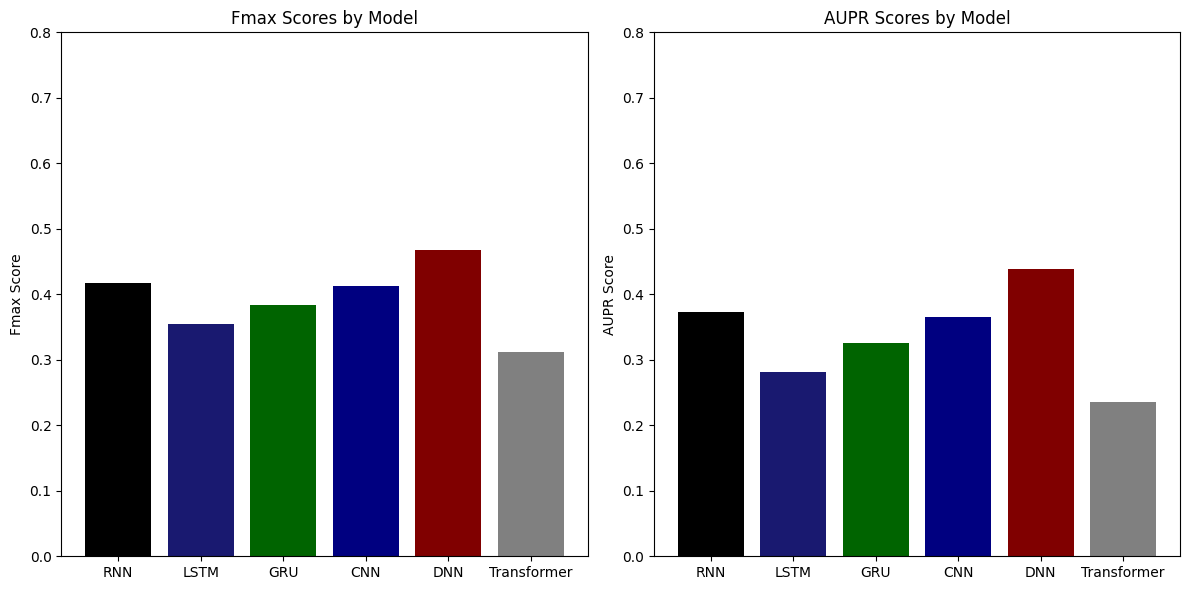

In [ ]:
import matplotlib.pyplot as plt

models = [model_rnn_simple, model_lstm, model_gru, model_cnn, model_dnn, model_transformer]
model_names = ["RNN", "LSTM", "GRU", "CNN", "DNN", "Transformer"]
fmax_scores = []
aupr_scores = []
colors = ['black', 'midnightblue', 'darkgreen', 'navy', 'maroon', 'gray']  # Liste des couleurs sombres

# Évaluer chaque modèle
for model in models:
    fmax, aupr = evaluate_model(model, X_test, y_test)
    fmax_scores.append(fmax)
    aupr_scores.append(aupr)

# Création des graphiques
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Graphique pour Fmax
for i, name in enumerate(model_names):
    ax[0].bar(name, fmax_scores[i], color=colors[i])
ax[0].set_title('Fmax Scores by Model')
ax[0].set_ylabel('Fmax Score')
ax[0].set_ylim([0, 0.8])

# Graphique pour AUPR
for i, name in enumerate(model_names):
    ax[1].bar(name, aupr_scores[i], color=colors[i])
ax[1].set_title('AUPR Scores by Model')
ax[1].set_ylabel('AUPR Score')
ax[1].set_ylim([0, 0.8])

plt.tight_layout()
plt.show()



---
# **Weighted Average ev without opt threshold**
---



In [ ]:
def evaluate_model(model, X_test, y_test):
    # Convertir les DataFrames en numpy arrays si nécessaire
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.values

    # Prédire les probabilités pour chaque classe
    y_pred_probs = model.predict(X_test)

    # Calcul de la précision et du rappel pour chaque label
    precisions, recalls, thresholds = precision_recall_curve(y_test.ravel(), y_pred_probs.ravel())

    # Calcul de Fmax
    f1_scores = 2 * (precisions * recalls) / (np.maximum(precisions + recalls, 1e-5))
    avgFmax = np.average(f1_scores, weights=recalls)  # Weighted average using recalls as weights

    # Calcul de AUPR
    aupr = auc(recalls, precisions)

    return avgFmax, aupr


# Liste des modèles et leurs noms pour l'affichage
models = [
    (model_rnn_simple, "RNN"),
    (model_lstm, "LSTM"),
    (model_gru, "GRU"),
    (model_cnn, "CNN"),
    (model_dnn, "DNN"),
    (model_transformer, "Transformer")
]

# Boucle pour évaluer chaque modèle et imprimer les résultats
for model, name in models:
    avgFmax, aupr = evaluate_model(model, X_test, y_test)
    print(f"{name} - Fmax: {avgFmax}, AUPR: {aupr}")


445/445 [==============================] - 1s 3ms/step
RNN - Fmax: 0.11188861062931693, AUPR: 0.3727104187719302
445/445 [==============================] - 2s 4ms/step
LSTM - Fmax: 0.10026235485613284, AUPR: 0.2819097871255677
445/445 [==============================] - 2s 4ms/step
GRU - Fmax: 0.10448195155283721, AUPR: 0.32614523366176024
445/445 [==============================] - 2s 5ms/step
CNN - Fmax: 0.11165230287274723, AUPR: 0.3655420054991424
445/445 [==============================] - 16s 35ms/step
DNN - Fmax: 0.12221949062564995, AUPR: 0.4381910598596209
445/445 [==============================] - 122s 273ms/step
Transformer - Fmax: 0.0826592852709485, AUPR: 0.23611410830284082


# **Evaluting models with optimal threshold**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score

def evaluate_model(model, X_test, y_test):
    # Convert DataFrames to numpy arrays if necessary
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.values

    # Predict probabilities for each class
    y_pred_probs = model.predict(X_test)

    # Calculate optimal thresholds for each label and their F1 and AUPR scores
    optimal_thresholds = []
    f1_scores_per_label = []
    auprs_per_label = []

    for i in range(y_test.shape[1]):
        precision, recall, thresholds = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)  # Adding epsilon to avoid division by zero
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_thresholds.append(optimal_threshold)

        # Apply optimal threshold to the predictions
        y_pred_optimal = (y_pred_probs[:, i] >= optimal_threshold).astype(int)

        # Calculate F1 score and AUPR for the current label
        f1 = f1_score(y_test[:, i], y_pred_optimal, average='binary')
        f1_scores_per_label.append(f1)

        # Calculate AUPR for the current label using precision-recall curve
        aupr = auc(recall, precision)
        auprs_per_label.append(aupr)

    # Calculate overall Fmax as the maximum of the F1 scores for each label
    overall_fmax = np.max(f1_scores_per_label)

    # Calculate the max AUPR
    overall_aupr = np.max(auprs_per_label)

    return overall_fmax, overall_aupr, optimal_thresholds

# List of models and their names for display
models = [
    (model_rnn_simple, "RNN"),
    (model_lstm, "LSTM"),
    (model_gru, "GRU"),
    (model_cnn, "CNN"),
    (model_dnn, "DNN"),
    (model_transformer, "Transformer")
]

# Loop to evaluate each model and print the results
for model, name in models:
    overall_fmax, overall_aupr, optimal_thresholds = evaluate_model(model, X_test, y_test)
    print(f"{name} - Overall Fmax: {overall_fmax}, Overall AUPR: {overall_aupr}")
    print(f"{name} - Optimal Thresholds: {optimal_thresholds}")

445/445 [==============================] - 1s 3ms/step
RNN - Overall Fmax: 0.7932260645390701, Overall AUPR: 0.790664267771124
RNN - Optimal Thresholds: [0.4188921, 0.43831196, 0.41856948, 0.40915227, 0.34244898, 0.3184508, 0.32681265, 0.35468993, 0.3016447, 0.3081158, 0.3449024, 0.31723067, 0.3002939, 0.27564365, 0.27633065, 0.31614473, 0.22808656, 0.25076747, 0.24051848, 0.29446185, 0.24568169, 0.24185385, 0.26297745, 0.22704047, 0.24258146, 0.24419188, 0.23445703, 0.22337367, 0.25379318, 0.22703187, 0.19140112, 0.25827736, 0.19486433, 0.21028882, 0.19019186, 0.22428773, 0.23539053, 0.25365484, 0.17245623, 0.19927451, 0.18833919, 0.22028635, 0.22180894, 0.20394467, 0.22896957, 0.23852634, 0.16981938, 0.2001004, 0.2322171, 0.24440329, 0.14897542, 0.21808806, 0.22390233, 0.1444164, 0.27380645, 0.22218978, 0.20262185, 0.22705072, 0.20114288, 0.19422317, 0.20377952, 0.20625538, 0.19193356, 0.2006753, 0.14306442, 0.23107038, 0.23172925, 0.21079323, 0.17008254, 0.13566822, 0.22898868, 0.22

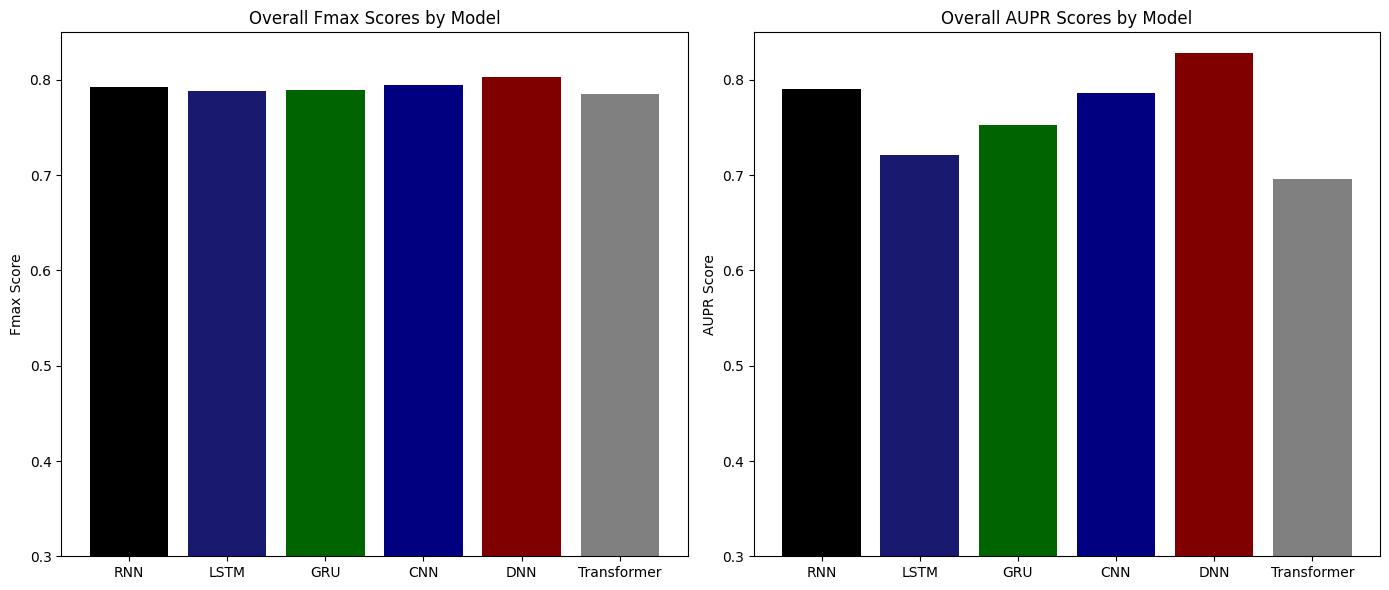

In [ ]:
# Dummy data - replace these with your actual Fmax and AUPR values
fmax_scores = [0.793, 0.788, 0.789, 0.795, 0.803, 0.785]
aupr_scores = [0.79, 0.721, 0.753, 0.786, 0.828, 0.696]

# Model names and their corresponding colors
models = ["RNN", "LSTM", "GRU", "CNN", "DNN", "Transformer"]
colors = ['black', 'midnightblue', 'darkgreen', 'navy', 'maroon', 'gray']

# Creating the plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for Fmax scores
ax[0].bar(models, fmax_scores, color=colors)
ax[0].set_title('Overall Fmax Scores by Model')
ax[0].set_ylabel('Fmax Score')
ax[0].set_ylim([0.3, 0.85])  # Adjust the limits based on your actual data

# Bar plot for AUPR scores
ax[1].bar(models, aupr_scores, color=colors)
ax[1].set_title('Overall AUPR Scores by Model')
ax[1].set_ylabel('AUPR Score')
ax[1].set_ylim([0.3, 0.85])  # Adjust the limits based on your actual data

# Show the plots
plt.tight_layout()
plt.show()



---
# **Weighted Average ev with opt threshold**
---



In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score

def evaluate_model(model, X_test, y_test):
    # Convert DataFrames to numpy arrays if necessary
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.values

    # Predict probabilities for each class
    y_pred_probs = model.predict(X_test)

    # Calculate optimal thresholds for each label and their F1 and AUPR scores
    optimal_thresholds = []
    f1_scores_per_label = []
    auprs_per_label = []

    for i in range(y_test.shape[1]):
        precision, recall, thresholds = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)  # Adding epsilon to avoid division by zero
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_thresholds.append(optimal_threshold)

        # Apply optimal threshold to the predictions
        y_pred_optimal = (y_pred_probs[:, i] >= optimal_threshold).astype(int)

        # Calculate F1 score and AUPR for the current label
        f1 = f1_score(y_test[:, i], y_pred_optimal, average='binary')
        aupr = average_precision_score(y_test[:, i], y_pred_probs[:, i])

        f1_scores_per_label.append(f1)
        auprs_per_label.append(aupr)

    # Apply the optimal thresholds to the entire prediction matrix
    y_pred_optimized = (y_pred_probs >= np.array(optimal_thresholds)).astype(int)

    # Calculate the overall Fmax using the optimized predictions (micro-averaged F1 score)
    overall_fmax = f1_score(y_test, y_pred_optimized, average='weighted')

   # Calculate the overall AUPR as the average of AUPR scores for each label
    overall_aupr = np.mean(auprs_per_label)

    return overall_fmax, overall_aupr, optimal_thresholds

# List of models and their names for display
models = [
    (model_rnn_simple, "RNN"),
    (model_lstm, "LSTM"),
    (model_gru, "GRU"),
    (model_cnn, "CNN"),
    (model_dnn, "DNN"),
    (model_transformer, "Transformer")
]

# Loop to evaluate each model and print the results
for model, name in models:
    overall_fmax, overall_aupr, optimal_thresholds = evaluate_model(model, X_test, y_test)
    print(f"{name} - Overall Fmax: {overall_fmax}, Overall AUPR: {overall_aupr}")
    print(f"{name} - Optimal Thresholds: {optimal_thresholds}")

445/445 [==============================] - 2s 3ms/step
RNN - Overall Fmax: 0.38463268982499815, Overall AUPR: 0.13009342871901217
RNN - Optimal Thresholds: [0.4188921, 0.43831196, 0.41856948, 0.40915227, 0.34244898, 0.3184508, 0.32681265, 0.35468993, 0.3016447, 0.3081158, 0.3449024, 0.31723067, 0.3002939, 0.27564365, 0.27633065, 0.31614473, 0.22808656, 0.25076747, 0.24051848, 0.29446185, 0.24568169, 0.24185385, 0.26297745, 0.22704047, 0.24258146, 0.24419188, 0.23445703, 0.22337367, 0.25379318, 0.22703187, 0.19140112, 0.25827736, 0.19486433, 0.21028882, 0.19019186, 0.22428773, 0.23539053, 0.25365484, 0.17245623, 0.19927451, 0.18833919, 0.22028635, 0.22180894, 0.20394467, 0.22896957, 0.23852634, 0.16981938, 0.2001004, 0.2322171, 0.24440329, 0.14897542, 0.21808806, 0.22390233, 0.1444164, 0.27380645, 0.22218978, 0.20262185, 0.22705072, 0.20114288, 0.19422317, 0.20377952, 0.20625538, 0.19193356, 0.2006753, 0.14306442, 0.23107038, 0.23172925, 0.21079323, 0.17008254, 0.13566822, 0.22898868, 0

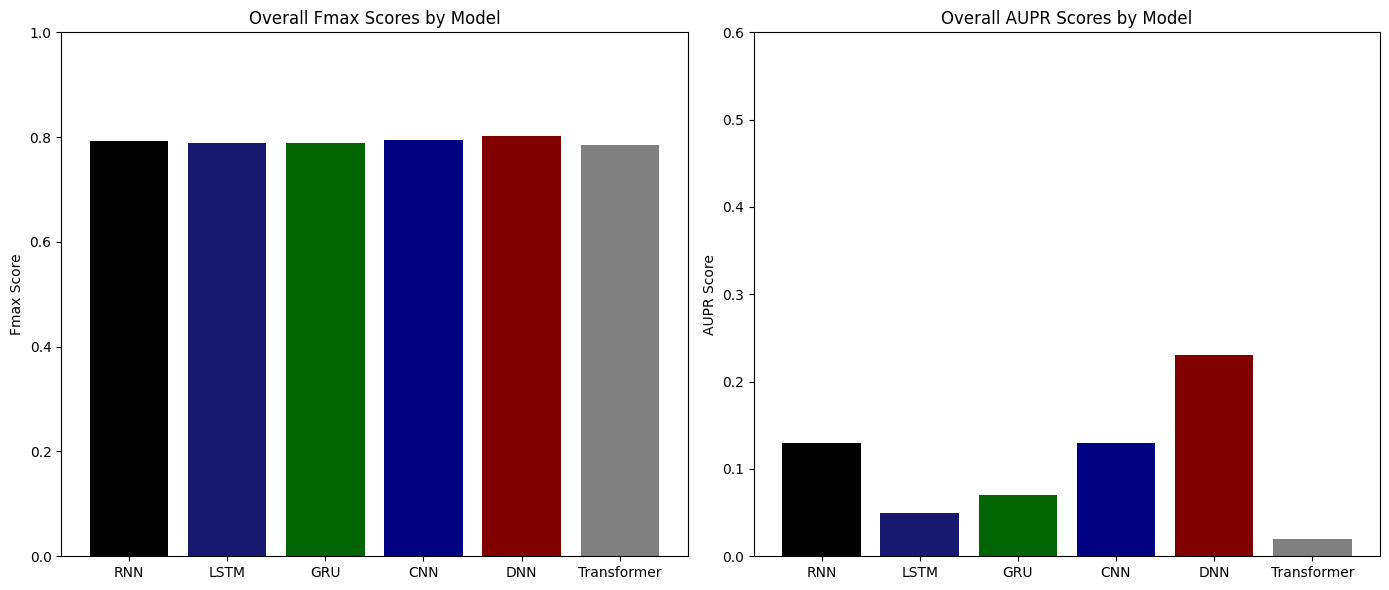

In [ ]:
# Dummy data - replace these with your actual Fmax and AUPR values
fmax_scores = [0.793, 0.788, 0.789, 0.795, 0.803, 0.785]
aupr_scores = [0.13, 0.05, 0.07, 0.13, 0.23, 0.02]

# Model names and their corresponding colors
models = ["RNN", "LSTM", "GRU", "CNN", "DNN", "Transformer"]
colors = ['black', 'midnightblue', 'darkgreen', 'navy', 'maroon', 'gray']

# Creating the plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for Fmax scores
ax[0].bar(models, fmax_scores, color=colors)
ax[0].set_title('Overall Fmax Scores by Model')
ax[0].set_ylabel('Fmax Score')
ax[0].set_ylim([0, 1])  # Adjust the limits based on your actual data

# Bar plot for AUPR scores
ax[1].bar(models, aupr_scores, color=colors)
ax[1].set_title('Overall AUPR Scores by Model')
ax[1].set_ylabel('AUPR Score')
ax[1].set_ylim([0, 0.6])  # Adjust the limits based on your actual data

# Show the plots
plt.tight_layout()
plt.show()

# Model Evaluation with Optimal Threshold Determination


In [ ]:
def evaluate_model(model, X_test, y_test):
    # Convertir les DataFrames en numpy arrays si nécessaire
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.values

    # Prédire les probabilités pour chaque classe
    y_pred_probs = model.predict(X_test)

    # Calcul de la précision et du rappel pour chaque label
    precisions, recalls, thresholds = precision_recall_curve(y_test.ravel(), y_pred_probs.ravel())

    # Calcul de Fmax et du seuil optimal
    f1_scores = 2 * (precisions * recalls) / (np.maximum(precisions + recalls, 1e-5))
    max_f1_index = np.argmax(f1_scores)
    fmax = f1_scores[max_f1_index]
    optimal_threshold = thresholds[max_f1_index]

    # Application du seuil optimal pour obtenir des prédictions binaires
    y_pred = (y_pred_probs.ravel() >= optimal_threshold).astype(int)

    # Calcul de AUPR
    aupr = auc(recalls, precisions)

    return fmax, aupr, optimal_threshold

# Liste des modèles et leurs noms pour l'affichage
models = [
    (model_rnn_simple, "RNN"),
    (model_lstm, "LSTM"),
    (model_gru, "GRU"),
    (model_cnn, "CNN"),
    (model_dnn, "DNN"),
    (model_transformer, "Transformer")
]

# Boucle pour évaluer chaque modèle et imprimer les résultats
for model, name in models:
    fmax, aupr, optimal_threshold = evaluate_model(model, X_test, y_test)
    print(f"{name} - Fmax: {fmax}, AUPR: {aupr}, Optimal Threshold: {optimal_threshold}")

445/445 [==============================] - 2s 4ms/step
RNN - Fmax: 0.4167270094134685, AUPR: 0.3727104187719302, Optimal Threshold: 0.22010602056980133
445/445 [==============================] - 2s 5ms/step
LSTM - Fmax: 0.35393138791625794, AUPR: 0.2819097871255677, Optimal Threshold: 0.1656990796327591
445/445 [==============================] - 2s 5ms/step
GRU - Fmax: 0.38387056693528343, AUPR: 0.32614523366176024, Optimal Threshold: 0.17735426127910614
445/445 [==============================] - 3s 6ms/step
CNN - Fmax: 0.41277642364047373, AUPR: 0.3655420054991424, Optimal Threshold: 0.22051388025283813
445/445 [==============================] - 18s 40ms/step
DNN - Fmax: 0.4672158488563719, AUPR: 0.4381910598596209, Optimal Threshold: 0.23334179818630219
445/445 [==============================] - 139s 312ms/step
Transformer - Fmax: 0.3119880583839288, AUPR: 0.23611410830284082, Optimal Threshold: 0.1440984159708023


# **DNN Confusion Matrix**

445/445 [==============================] - 2s 4ms/step


<Figure size 800x600 with 0 Axes>

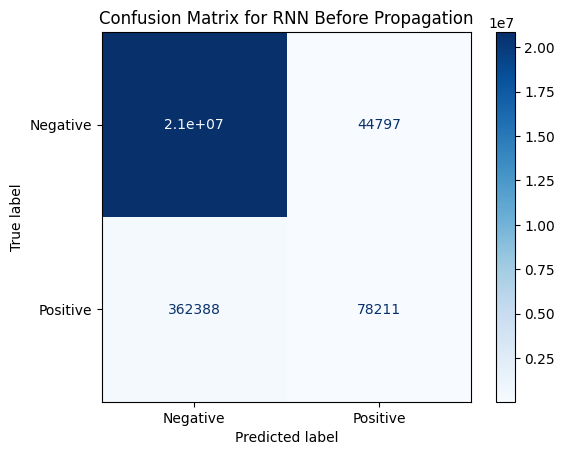

Global Confusion Matrix:
                          Predicted
               ------------------------------
               Negative     | Positive
Actual Negative    20852104        | 44797
Actual Positive    362388        | 78211


In [ ]:
# Assurer que y_test est un array numpy
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values

# Faire des prédictions
predictions = model_rnn_simple.predict(X_test)

# Seuil pour convertir les probabilités en étiquettes binaires
binary_predictions = (predictions > 0.5).astype(int)  # Seuil de 0.5

# Initialiser une matrice de confusion globale
global_confusion_matrix = np.zeros((2, 2), dtype=int)

# Calculer les matrices de confusion pour chaque étiquette et les sommer
NUM_LABELS = 1500  # Assure-toi que ce nombre correspond au nombre d'étiquettes dans ton modèle
for i in range(NUM_LABELS):
    cm = confusion_matrix(y_test[:, i], binary_predictions[:, i])
    global_confusion_matrix += cm  # Ajouter la matrice de cette étiquette à la matrice globale

# Afficher la matrice de confusion globale
disp = ConfusionMatrixDisplay(confusion_matrix=global_confusion_matrix, display_labels=['Negative', 'Positive'])
plt.figure(figsize=(8, 6))  # Ajuster la taille de la figure si nécessaire
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for RNN Before Propagation')
plt.show()

# Imprimer la matrice de confusion sous forme de tableau
print("Global Confusion Matrix:")
print("                          Predicted")
print("               ------------------------------")
print(f"               Negative     | Positive")
print(f"Actual Negative    {global_confusion_matrix[0, 0]}        | {global_confusion_matrix[0, 1]}")
print(f"Actual Positive    {global_confusion_matrix[1, 0]}        | {global_confusion_matrix[1, 1]}")

445/445 [==============================] - 12s 27ms/step


<Figure size 800x600 with 0 Axes>

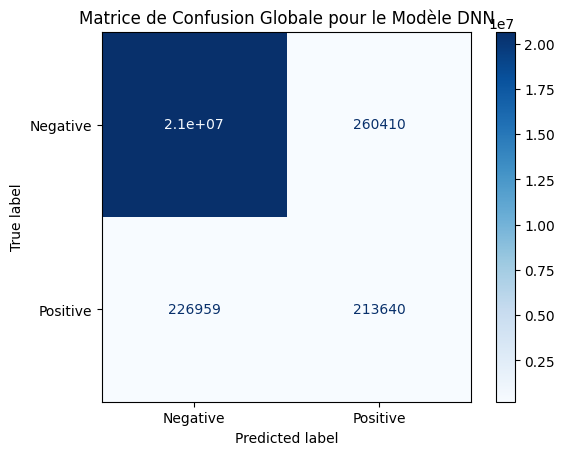

Global Confusion Matrix:
                          Predicted
               ------------------------------
               Negative     | Positive
Actual Negative    20636491        | 260410
Actual Positive    226959        | 213640


In [ ]:
# Assurer que y_test est un array numpy
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values

# Faire des prédictions
predictions = model_dnn.predict(X_test)

# Seuil pour convertir les probabilités en étiquettes binaires
binary_predictions = (predictions > 0.23).astype(int)

# Initialiser une matrice de confusion globale
global_confusion_matrix = np.zeros((2, 2), dtype=int)

# Calculer les matrices de confusion pour chaque étiquette et les sommer
NUM_LABELS = 1500  # Assure-toi que ce nombre correspond au nombre d'étiquettes dans ton modèle
for i in range(NUM_LABELS):
    cm = confusion_matrix(y_test[:, i], binary_predictions[:, i])
    global_confusion_matrix += cm  # Ajouter la matrice de cette étiquette à la matrice globale

# Afficher la matrice de confusion globale
disp = ConfusionMatrixDisplay(confusion_matrix=global_confusion_matrix, display_labels=['Negative', 'Positive'])
plt.figure(figsize=(8, 6))  # Ajuster la taille de la figure si nécessaire
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion Globale pour le Modèle DNN')
plt.show()

# Imprimer la matrice de confusion sous forme de tableau
print("Global Confusion Matrix:")
print("                          Predicted")
print("               ------------------------------")
print(f"               Negative     | Positive")
print(f"Actual Negative    {global_confusion_matrix[0, 0]}        | {global_confusion_matrix[0, 1]}")
print(f"Actual Positive    {global_confusion_matrix[1, 0]}        | {global_confusion_matrix[1, 1]}")